In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as  plt
import seaborn as sns
import pandas as pd

#**1-Objective**

- The main idea is to develop an **NLP** model for product testimonial analysis.

##**1.2 What does this solve??**

- Several companies want to understand how their customers are receiving their products, how customers are evaluating their products.

- Developing a sentiment analysis model would help the company understand the engagement of the products the company sells.

#**2-Development planning** .

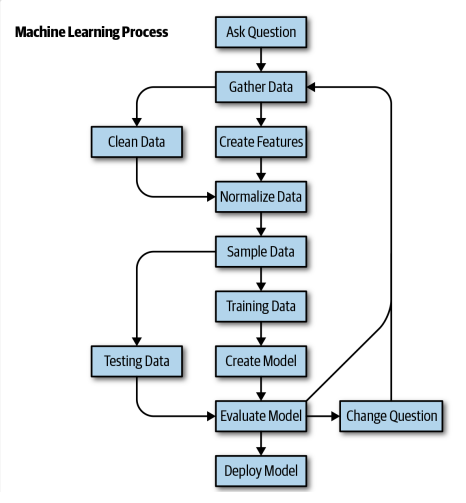

- For model training, we will use a dataset from **Twitter Sentiment**.

## **1-Getting the dataset**

In [ ]:
class GetDataCv:
  def __init__(self):
    self.PATH=None
    self.data=None

  def getData(self):
    try:
      if self.PATH is None:
         self.PATH='/content/train (1).csv'

    except (ValueError,TypeError) as e:
      raise type(e)(f'Error')

  def loadData(self):
    self.data=pd.read_csv(self.PATH,encoding='utf-8')
    return self.data

In [ ]:
getData=GetDataCv()

In [ ]:
getData.getData()

In [ ]:
df=getData.loadData()

- **Viewing the data**

In [ ]:
df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


##**2 - Checking null data**

In [ ]:
df.isna().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [ ]:
dataset=df.loc[:,('text','sentiment')]

In [ ]:
dataset.isna().sum()

,0
text,1
sentiment,0


In [ ]:
dataset['sentiment'].value_counts(dropna=False)

,count
sentiment,
neutral,11118
positive,8582
negative,7781


In [ ]:
dataset.loc[:,('text')][dataset['text'].isna()==True].count()

0

In [ ]:
dataset.loc[dataset['text'].isna()]


,text,sentiment
314,NaN,neutral


In [ ]:
dataset.fillna('yes',inplace=True)

In [ ]:
np.unique(
    dataset['sentiment']
)

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
dataset['sentiment'].replace(
    {
        'negative':0,
        'neutral':1,
        'positive':2
    },
    inplace=True
)

In [ ]:
dataset['sentiment'].value_counts()

,count
sentiment,
1,11118
2,8582
0,7781


##**3-Data Preprocessing**

In [ ]:
dataset.to_csv('sentiment_review.cv',index=False)

- Generally, I like to use tensorflow, **TFRecordWriter**, allows you to create **a dataset**

In [ ]:
with tf.io.TFRecordWriter('sentiment_analysis.tfrecords') as f:
  f.write('/content/sentiment_review.cv')


- Next, we read the file that is in **the dataset**
- This allows you to create a **new dataset**.

- The **interleave function** is used to create a dataset merging other datasets into one only

In [ ]:
dataset=tf.data.TFRecordDataset(['/content/sentiment_analysis.tfrecords']).interleave(
    lambda filepaths:tf.data.TextLineDataset(filepaths).skip(1)
)

- We apply the lambda function to with tf.data.**TextLineDataset**... This function allows you to read rows from the interleaved data set, in this case within the interleave

- Viewing the **new dataset**

In [ ]:
for idx_values  in dataset.take(10):
  print(idx_values)

tf.Tensor(b'" I`d have responded, if I were going",1', shape=(), dtype=string)
tf.Tensor(b' Sooo SAD I will miss you here in San Diego!!!,0', shape=(), dtype=string)
tf.Tensor(b'my boss is bullying me...,0', shape=(), dtype=string)
tf.Tensor(b' what interview! leave me alone,0', shape=(), dtype=string)
tf.Tensor(b'" Sons of ****, why couldn`t they put them on the releases we already bought",0', shape=(), dtype=string)
tf.Tensor(b'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth,1', shape=(), dtype=string)
tf.Tensor(b'2am feedings for the baby are fun when he is all smiles and coos,2', shape=(), dtype=string)
tf.Tensor(b'Soooo high,1', shape=(), dtype=string)
tf.Tensor(b' Both of you,1', shape=(), dtype=string)
tf.Tensor(b' Journey!? Wow... u just became cooler.  hehe... (is that possible!?),2', shape=(), dtype=string)


- Once we have the dataset, we need to **preprocess** the text

In [ ]:
@tf.function
def preprocess(lines):
  defs =[""]*1 +  [tf.constant([],dtype=tf.int64)]  #specifying the column type, and the number of columns I'm passing as a feature
  fields=tf.io.decode_csv(lines,record_defaults=defs)
  X=fields[0]
  y=fields[-1]
  return X,y

- Basically this **pre-processing** function aims to separate the response variable and the predictor variable, it receives as an argument lines, **tuples of data that are in csv format**

- I'm also specifying the type of data it should expect, and the return format if it finds **null data**

In [ ]:
dataset=dataset.map(preprocess)

- The map function is responsible for **applying a specific operation to each element of the dataset**

-  Viewing the **new dataset**

In [ ]:
list(dataset.take(10).as_numpy_iterator())

[(b' I`d have responded, if I were going', 1),
 (b' Sooo SAD I will miss you here in San Diego!!!', 0),
 (b'my boss is bullying me...', 0),
 (b' what interview! leave me alone', 0),
 (b' Sons of ****, why couldn`t they put them on the releases we already bought',
  0),
 (b'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth',
  1),
 (b'2am feedings for the baby are fun when he is all smiles and coos', 2),
 (b'Soooo high', 1),
 (b' Both of you', 1),
 (b' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)', 2)]

- We can see that both the feature text and the response variable are **already separated.**

- Now we need to **preprocess the text**, this data needs to be clean to be fed to the ML algorithms

- Let's check how many unique characters w**e have in the dataset**

In [ ]:
tokenizer=tf.keras.preprocessing.text.Tokenizer()

In [ ]:
df=df.loc[:,('text')].to_list()

In [ ]:
with open('text.txt',mode='w',encoding='utf-8') as f:
  for lines in df:
    f.writelines(f'{lines}')

In [ ]:
with open('/content/text.txt',mode='r')  as files:
  textToTokenizer=files.read()

In [ ]:
textToTokenizer[:100]

' I`d have responded, if I were going Sooo SAD I will miss you here in San Diego!!!my boss is bullyin'

- Let's tokenize each character to  a **specific id**

In [ ]:
tokenizer.fit_on_texts(textToTokenizer)

In [ ]:
tokenizer.texts_to_sequences(['t','h','i'])

[[2], [8], [5]]

- Now, we've mapped each character to a **specific id**

In [ ]:
max_id=tokenizer.index_word

In [ ]:
print(max_id,end=' ')

{1: 'e', 2: 't', 3: 'o', 4: 'a', 5: 'i', 6: 'n', 7: 's', 8: 'h', 9: 'r', 10: 'l', 11: 'd', 12: 'm', 13: 'y', 14: 'u', 15: 'g', 16: 'w', 17: 'c', 18: 'p', 19: 'f', 20: 'b', 21: 'k', 22: 'v', 23: 'j', 24: 'x', 25: 'z', 26: '2', 27: '0', 28: '1', 29: '3', 30: "'", 31: '4', 32: 'q', 33: '5', 34: '6', 35: '8', 36: '7', 37: '9', 38: 'ï', 39: '¿', 40: '½', 41: 'â', 42: '\xa0', 43: '´'} 

In [ ]:
max_id

{1: 'e',
 2: 't',
 3: 'o',
 4: 'a',
 5: 'i',
 6: 'n',
 7: 's',
 8: 'h',
 9: 'r',
 10: 'l',
 11: 'd',
 12: 'm',
 13: 'y',
 14: 'u',
 15: 'g',
 16: 'w',
 17: 'c',
 18: 'p',
 19: 'f',
 20: 'b',
 21: 'k',
 22: 'v',
 23: 'j',
 24: 'x',
 25: 'z',
 26: '2',
 27: '0',
 28: '1',
 29: '3',
 30: "'",
 31: '4',
 32: 'q',
 33: '5',
 34: '6',
 35: '8',
 36: '7',
 37: '9',
 38: 'ï',
 39: '¿',
 40: '½',
 41: 'â',
 42: '\xa0',
 43: '´'}

- Now, let's create a preprocessing function to **remove unwanted characters**

In [ ]:
@tf.function
def preprocess_strings(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 200)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z]", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b'<pad>'),y_batch

**This function**
- 1-We don't need to analyze all strings to decide if a comment is positive or not

- 2 - We removed characters that are not necessary to parse, this was done by doing a pattern search with regex

- 3-Divide each string by space, this creates lists of lists

- 4 - Recurrent neural networks (LSTMs, GRUs) need to process instances of the same size, so we add pad values to have the same sequence length

In [ ]:
ExampleDataset=dataset.batch(32).map(preprocess_strings)

In [ ]:
for idx_values in ExampleDataset.take(1):
  print(idx_values)

(<tf.Tensor: shape=(32, 30), dtype=string, numpy=
array([[b'I', b'd', b'have', b'responded', b'if', b'I', b'were',
        b'going', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'Sooo', b'SAD', b'I', b'will', b'miss', b'you', b'here', b'in',
        b'San', b'Diego', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'my', b'boss', b'is', b'bullying', b'me', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pa

- **Why add pad ?**

Let's assume we have this string tensor

In [ ]:
text=tf.constant(['this movie is good','ok','good movie'])

- Now, let's apply the **split function** to this tensor

In [ ]:
text=tf.strings.split(text)

- Now, let's add the pad to see how it helps to have sequences of the **same size**

In [ ]:
text.to_tensor(default_value=b'<pad>')

<tf.Tensor: shape=(3, 4), dtype=string, numpy=
array([[b'this', b'movie', b'is', b'good'],
       [b'ok', b'<pad>', b'<pad>', b'<pad>'],
       [b'good', b'movie', b'<pad>', b'<pad>']], dtype=object)>

- We can see that we now have **sequences of the same length**

- We can see that the function has divided each sequence by space, but for **LSTMs GRU models**, it is necessary to have sequences of the **same size**

- Now we need to count how many times words appear in every text, this will be useful for us to create a **lookup table**.. where each word will be mapped to a **specific id**

In [ ]:
from collections import Counter

In [ ]:
vocabulary=Counter()

In [ ]:
for X_batch , y_batch in dataset.batch(32).map(preprocess_strings):
  for reviews in X_batch:
    vocabulary.update(list(reviews.numpy()))

- What are we doing?

- Basically, we're going through each **batch (32)** and for each batch we're applying the **pre-processing function** to **trim the strings**, **clean up characters**, **split**, and assign pad values where lists **of different sizes**.

- Basically, we're counting how many times each word **occurs in the dataset**

In [ ]:
vocabulary.most_common()[:10]

[(b'<pad>', 385883),
 (b'I', 11544),
 (b'to', 9898),
 (b'the', 8454),
 (b'a', 6596),
 (b'i', 5181),
 (b'my', 4984),
 (b'you', 4817),
 (b'and', 4816),
 (b'it', 4627)]

In [ ]:
words =[iten for iten in vocabulary.most_common()[:]]

In [ ]:
word=[]
counter=[]

In [ ]:
for idx_w in words:
  word.append(idx_w[0])
  counter.append(idx_w[1])

In [ ]:
dataWords=pd.DataFrame({
    'Words':word[:50],
    'Counter':counter[:50]
})

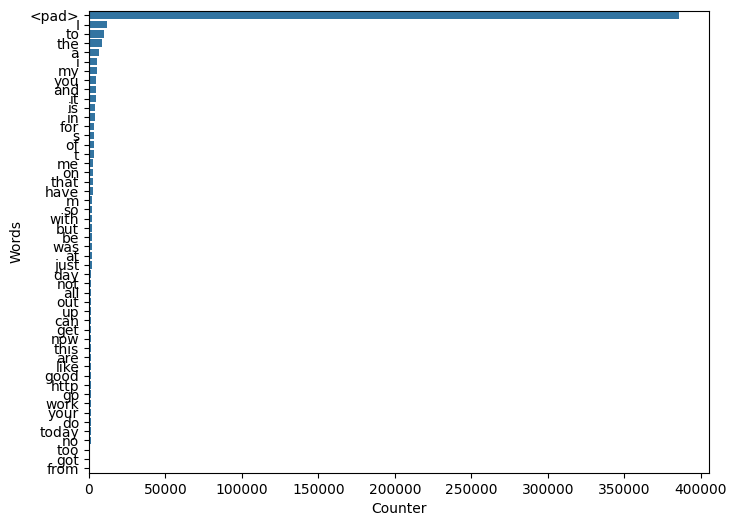

In [ ]:
plt.figure(
    figsize=(8,6)
)

sns.barplot(
    x='Counter',
    y='Words',
    data=dataWords
)
plt.show()

- We can see that the word that occurs the most in the vocabulary , and **'pad'**

- This is occurring because we have m**any sequences of arbitrary length**

- This way, we don't need all the **full** vocabulary to feed into the **model**

- Let's **truncate** the vocabulary with **only 1500 words**

In [ ]:
vocabulary_size=1500

truncated_vocab=[
    words for words , counter in vocabulary.most_common()[:vocabulary_size]
]

In [ ]:
truncated_vocab[:10]

[b'<pad>', b'I', b'to', b'the', b'a', b'i', b'my', b'you', b'and', b'it']

- Now we need to create a **lookup table**, and map each **vocabulary word to an index.**

- What is a **lookup table ?**

- A lookup table allows you to **map** each word of the word vocabulary to a **specific id**, this will be useful when we have to feed the data to the **embeddings layers.**

- **Let's take an example**

In [ ]:
ExamplesWords=truncated_vocab[:10]

In [ ]:
ExamplesWords=tf.constant([idx for idx in ExamplesWords[:]])

- Here we have created **10 indexes** for the 10 **words in the vocabulary.**

In [ ]:
ExamplesWords

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'<pad>', b'I', b'to', b'the', b'a', b'i', b'my', b'you', b'and',
       b'it'], dtype=object)>

In [ ]:
ExamplesIdWordsId=tf.range(len(ExamplesWords),dtype=tf.int64)

- Now, we need to create a table where each word will be **mapped to an index**.

In [ ]:
tableHash=tf.lookup.KeyValueTensorInitializer(ExamplesWords,ExamplesIdWordsId)

- After creating the **hash table**, we need to create a **lookup table**.

- Another piece of information that we need to be aware of is that there will be times that there will be words **outside the vocabulary**, to deal with this, we can create a set of **indexes different from the indexes that are already in use.**

In [ ]:
out_of_vocabulary=1000

In [ ]:
lookupTableExample=tf.lookup.StaticVocabularyTable(tableHash,1000)

- Now we can do a search, and see in which indexes **each word or mapped in the table**

In [ ]:
lookupTableExample.lookup(tf.constant(['the','a','i']))

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 4, 5])>

- We can see that each word has been mapped to a **specific index**

- Now, if I enter a word that hasn't been mapped to a specific index, then it's mapped to an index **outside of the vocabulary.**

In [ ]:
lookupTableExample.lookup(tf.constant(['this']))

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([29])>

- We can see that it's been mapped to an **index off the vocabulary**

## **Creating the training set**

- Now, we already have the word done ... We now need to code and prepare the data **from the dataset**

In [ ]:
idxVocabSize=tf.range(len(truncated_vocab),dtype=tf.int64)
tableHashVocab=tf.lookup.KeyValueTensorInitializer(truncated_vocab,idxVocabSize)
tableLookup=tf.lookup.StaticVocabularyTable(tableHashVocab,1000)

In [ ]:
@tf.function
def encodeWords(X_batch,y_batch):
  return tableLookup.lookup(X_batch),y_batch

In [ ]:
dataset_train=dataset.batch(32).map(preprocess_strings)
dataset_train=dataset_train.map(encodeWords)
dataset_train=dataset_train.prefetch(1)

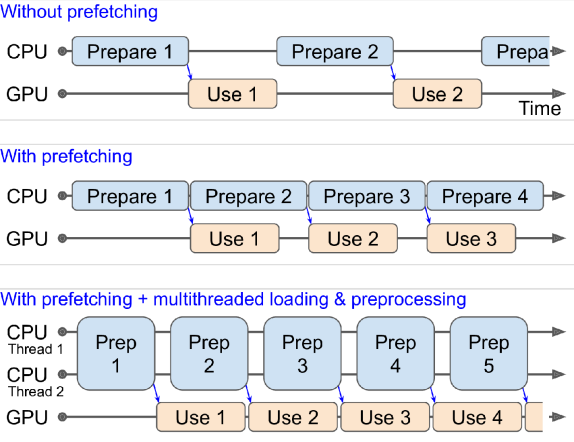

- The **prefetch** is very useful to avoid bottlenecks, its objective is to enable the **maximum use of the GPU**, in this case it is very important **to speed up training**

In [ ]:
for X_bath,y_batch  in dataset_train.take(1):
  print(f'X_batch={X_batch},y_batch={y_batch}')

X_batch=[[b'i' b'wanna' b'leave' b'work' b'already' b'Not' b'feelin' b'it' b'day'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>']
 [b'My' b'camera' b'is' b'brokennn' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>']
 [b'I' b'really' b'wish' b'someone' b'would' b'make' b'a' b'groupchat'
  b'theme' b'for' b'Adium' b'suited' b'for' b'IRC' b'yMous' b'has' b'way'
  b'too' b'low' b'contrast' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>']
 [b'good' b'as' b'cya' b'in' b'melbourne' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>

#**3-Preparing the Model Architecture**

 - For each different type of task there are different types of **neural network architectures**

- We want our model to **understand words.**
- **But, how?**

- This is possible thanks to the **embedding layers**, and the architectures that deal with data **sequences (RNNs)**

- Recurrent neural networks are useful for dealing with sequences.. A lot of data in the real world is sequences

- But, **how do they work?**

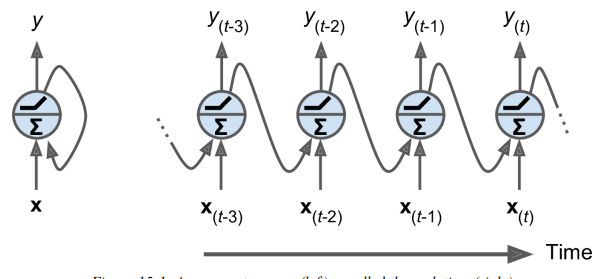

- When we deal with data that are sequences, the RNN layers receive the input data and for each instant(t) we consider the current **time (t) and the previous time t (t-1)**, we calculate a **linear combination** of the inputs at **instants (t) and (t-1)**.

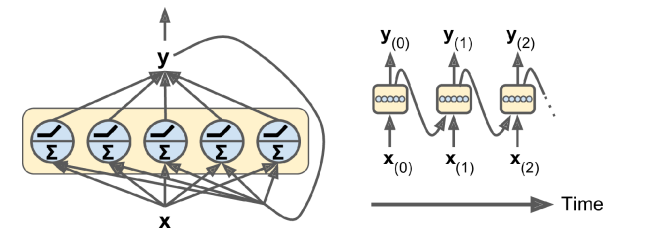

- Input format for a layer RNNs

$$
y(t) = \phi\left(W_x^\top x(t) + W_y^\top y(t-1) + b\right)
$$


- **Y** is an $m \times n$ matrix containing the layer's outputs at time step $t$ for each instance in the mini-batch, where $m$ is the number of instances in the mini-batch and $n$ is the number of neurons.
- **X** is an $m \times n$ matrix containing the inputs for all instances, where $n$ is the number of input features.
- $W_x$ is an $n \times n$ matrix containing the connection weights for the inputs at the current time step.
- $W_y$ is an $n \times n$ matrix containing the connection weights for the outputs from the previous time step.
- $b$ is a vector of size $n$ containing each neuron's bias term.


- The weight matrices $W_x$ and $W_y$ are often vertically concatenated into a single weight matrix $W$ of shape $(n + n) \times n$.

- The notation $[X \ Y]$ represents the horizontal concatenation of the matrices $X$ and $Y$.


- For our task, we will not use the **RNNs layer**, because.. RNN layers do not work well when we have very **long sequences**, this is because the hidden state h(t) **is updated every instant (t)**, that is, the hidden state h(t) is the memory

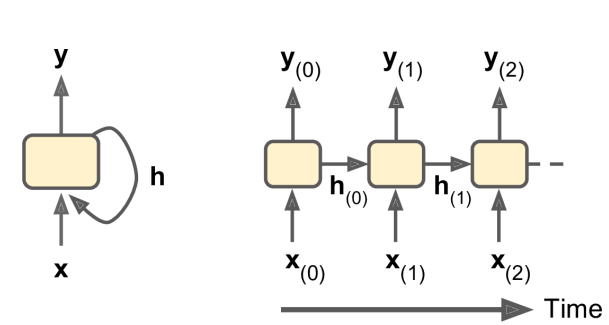

- The amount of **information** we consider at any given moment is very short when dealing with the hidden state **h(t)** of the **RNN architecture.**

## **3.1-The architecture of LSTM - GRU**

- **LSTM-(Long Short term Memory)**
- **GRU-(Gate Recurrent Unit)**

- The **GRU**, and the **LSTM** are extensions of the **RNNs**

- The idea of **LSTM/GRU** is to make the network learn what to **store** and what not to store, what to **add** and what to **forget** at each **moment of time**.

- The **LSTM/GRU** layers can recognize when an **input is important**, and can simply store that **information in long-term memory.**

- **Unlike RNNs**, **LSTM/GRU** layers have 2 hidden **states instead of 1.**

- **But how do they work ?**

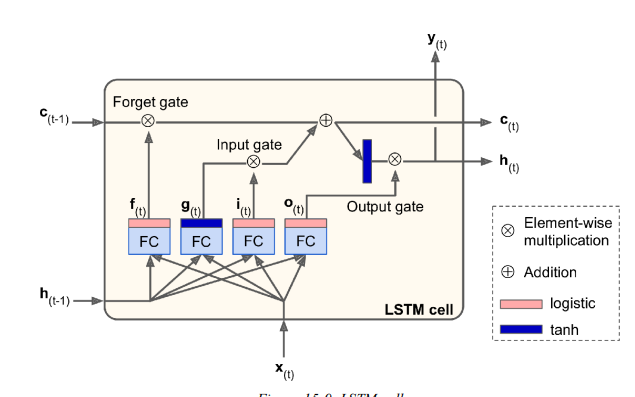

- The main layer is the one that **outputs g** . It has the
 usual role of
 analyzing the current inputs x and the previous (short-term)
 state h
 In a basic cell, there is nothing other than this layer,
 and its output goes straight out to **y and h**. In contrast, in an
 LSTM cell this layer’s output does not go straight out, but instead
 its **most important parts** are stored in the long-term state (and the
 rest is dropped).

- The three other layers are **gate controllers**. Since they use the
logistic activation function, their outputs range from 0 to 1. As
you can see, their outputs are fed to **element-wise multiplication**
operations, so if they **output 0  they close the gate**, and if they
output 1s they open it. **Specifically**

- The **forget gate** (**controlled by $f$** ) controls which parts of
the long-term state should be erased.

- The **input gate** (**controlled by i** ) controls which parts of
g should be added to the long-term state.

- Finally, the **output gate** (**controlled by o**) controls which
parts of the long-term state should be read and output at
this time step, both to h and to y .


- In short, an **LSTM cell can learn** to **recognize** an important input (that’s
the role of the **input gat**e), store it in the long-term state, preserve it for as
long as it is needed (that’s the role of the forget gate), and extract it
whenever it is needed. This explains why these cells have been amazingly
at capturing long-term patterns in time series, long texts, audio
recordings, and more.

- $$
i(t) = \sigma(W_{xi}^\top x(t) + W_{hi}^\top h(t-1) + b_i)
$$

$$
f(t) = \sigma(W_{xf}^\top x(t) + W_{hf}^\top h(t-1) + b_f)
$$

$$
o(t) = \sigma(W_{xo}^\top x(t) + W_{ho}^\top h(t-1) + b_o)
$$

$$
g(t) = \tanh(W_{xg}^\top x(t) + W_{hg}^\top h(t-1) + b_g)
$$

$$
c(t) = f(t) \odot c(t-1) + i(t) \odot g(t)
$$

$$
y(t) = h(t) = o(t) \odot \tanh(c(t))
$$


In this equation:
- $W_i$, $W_f$, $W_o$, and $W_g$ are the weight matrices of each of the four layers for their connection to the input vector $x$.
- $W_{hi}$, $W_{hf}$, $W_{ho}$, and $W_{hg}$ are the weight matrices of each of the four layers for their connection to the previous short-term state $h$.
- $b_i$, $b_f$, $b_o$, and $b_g$ are the bias terms for each of the four layers.

Note that TensorFlow initializes $b$ to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training.


- GRU Cells

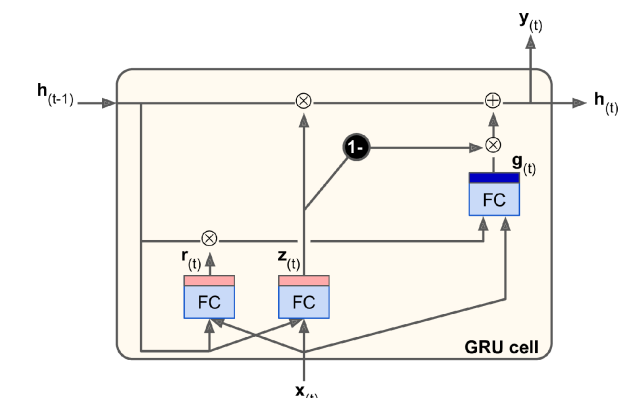

- Both state vectors are merged into a **single vector \( h \)**.

- A single gate controller **\( z \)** controls both the **forget gate** and the input gate. If the gate controller **outputs a 1**, the forget gate is open (= 1) and the input gate is closed (1 – 1 = 0). If it outputs a 0, the **opposite happens**. In other words, whenever a memory must be stored, the location where it will be stored is erased first. This is actually a frequent variant to the LSTM cell in and of itself.

- There is no **output gate**; the full state vector is output at every time step. However, there is a new gate controller **\( r \)** that controls which part of the previous state will be shown to the main layer \( g \).


**Equation**:

$$z(t) = \sigma \left( W_{xz}^\top x(t) + W_{hz}^\top h(t-1) + b_z \right)$$

$$r(t) = \sigma \left( W_{xr}^\top x(t) + W_{hr}^\top h(t-1) + b_r \right)$$

$$g(t) = \tanh \left( W_{xg}^\top x(t) + W_{hg}^\top \left( r(t) \otimes h(t-1) \right) + b_g \right)$$

$$h(t) = z(t) \otimes h(t-1) + \left( 1 - z(t) \right) \otimes g(t)$$


## **3.2-Embeddings**

- Now that we understand how data is processed in architectures, we now need to understand **how the network learns words**

- There are many techniques that are used in machine learning to make the **model learn words**.

- However, one of the great innovations is **word embeddings**

- Word embeddings are **trainable dense vectors**.. Each category can be represented as an **N** dimensional vector, these catagories are **words**.

- Unlike other techniques, word embeddings can encode **genders**, **that people, food, clothes are different things.. This is possible by performing a similarity calculation, measuring how each feature vector resembles another vector**

- Similar intances always end up in the **same space of embeddings.**

- **Example**

- Initially the embeddings are **initialized randomly**, during the training phase the weights are updated so that similar instances end up in the same **embedding space**

In [ ]:
len(ExamplesWords)

10

In [ ]:
out_of_vocabulary_examples=5
embeddings_dins=2

In [ ]:
embeddings=tf.random.uniform([len(ExamplesWords) +  out_of_vocabulary_examples,embeddings_dins])

In [ ]:
embeddings

<tf.Tensor: shape=(15, 2), dtype=float32, numpy=
array([[0.24633086, 0.97188103],
       [0.81796956, 0.61106515],
       [0.5278069 , 0.8685045 ],
       [0.61588717, 0.9638579 ],
       [0.14940655, 0.7434623 ],
       [0.18375742, 0.9763651 ],
       [0.46099508, 0.27782965],
       [0.66047394, 0.22518897],
       [0.31337178, 0.47026622],
       [0.60129046, 0.17077053],
       [0.08861613, 0.99225676],
       [0.3971572 , 0.089306  ],
       [0.85622513, 0.37244272],
       [0.8705255 , 0.2784071 ],
       [0.7296643 , 0.00242317]], dtype=float32)>

- The embeddigs have been **initialized randomly,** now we need to map each each row of these embeddings to a s**pecific category**

In [ ]:
embeddings=tf.Variable(embeddings)

- We need the embedding categories to be adjustable during training, so we use **tf. Variable**

In [ ]:
cat_idx_emb=lookupTableExample.lookup(ExamplesWords)

In [ ]:
embeddings_lines=tf.nn.embedding_lookup(embeddings,cat_idx_emb)

In [ ]:
embeddings_lines

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0.24633086, 0.97188103],
       [0.81796956, 0.61106515],
       [0.5278069 , 0.8685045 ],
       [0.61588717, 0.9638579 ],
       [0.14940655, 0.7434623 ],
       [0.18375742, 0.9763651 ],
       [0.46099508, 0.27782965],
       [0.66047394, 0.22518897],
       [0.31337178, 0.47026622],
       [0.60129046, 0.17077053]], dtype=float32)>

- Viewing the **embeddings before training**

In [ ]:
embeddingsSpace=pd.DataFrame({
    'Xembeddings':embeddings_lines[:10,0],
    'Yembeddings':embeddings_lines[:10,1],
    'data':truncated_vocab[:10]
})

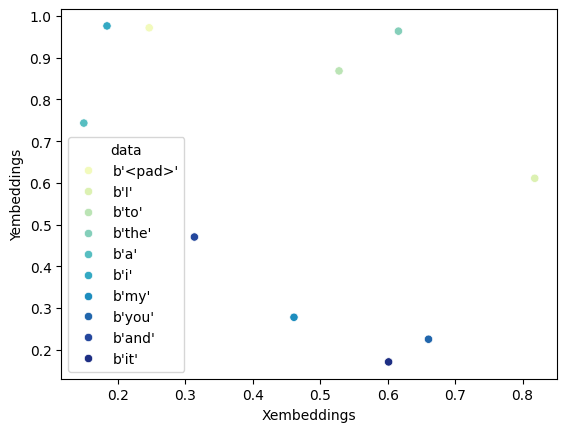

In [ ]:
sns.scatterplot(
    x='Xembeddings',
    y='Yembeddings',
    data=embeddingsSpace,
    hue='data',
    palette='YlGnBu'
)
plt.show()

- Initially we can see that some words **are far from others**, but during training, similar **instances will end up in the same embedding space**

- Now, we're ready to architect our model

$$\text{Att: The embeddings layer expects the following form: } \; [\text{Batch_size}, \text{Timestep}, \text{Dimensionality}]$$


In [ ]:
model=keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(truncated_vocab) + out_of_vocabulary,output_dim=2),
    keras.layers.GRU(128,return_sequences=True),
    keras.layers.GRU(128,return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(3,activation='softmax')
])

# **4-Training**

- The training of RNNs is called **Backwardpropagation through time**

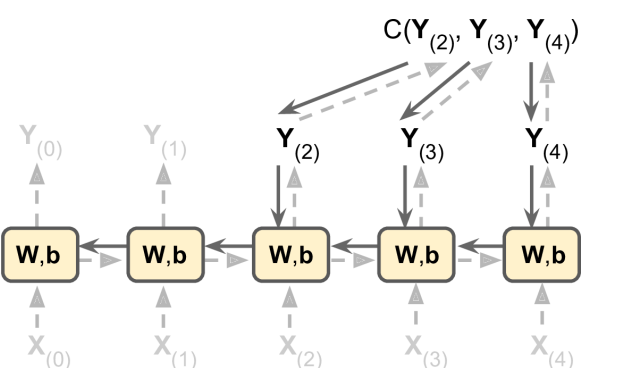

- At each instant of time, we calculate the **partial derivative** of the cost function with r**espect to the parameters of the model**

- **Compiling the Model**

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

- **Training**

In [ ]:
model_history=model.fit(
    dataset_train,
    epochs=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=20)
    ]
)

Epoch 1/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3990 - loss: 1.0893
Epoch 2/32
 13/859 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4145 - loss: 1.0850

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4026 - loss: 1.0879
Epoch 3/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5292 - loss: 0.9452
Epoch 4/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6689 - loss: 0.7452
Epoch 5/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7240 - loss: 0.6654
Epoch 6/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7369 - loss: 0.6345
Epoch 7/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7456 - loss: 0.6140
Epoch 8/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7556 - loss: 0.5985
Epoch 9/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7632 - loss: 0.5845
Epoch 10/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7701 - loss: 0.5703
Epoch 11/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7770 - loss: 0.5556
Epoch 12/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7851 - loss: 0.5399
Epoch 13/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accurac

- **Visualizing Model Performance**

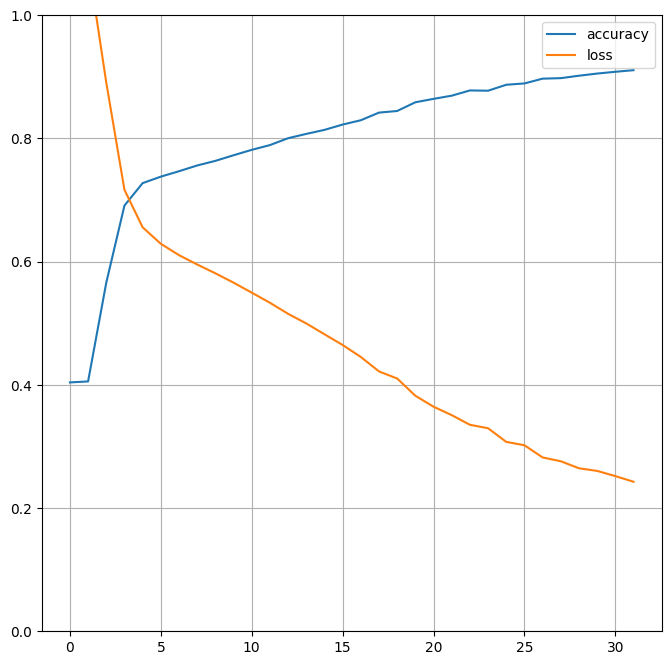

In [ ]:
pd.DataFrame(
    model_history.history
).plot(
    figsize=(8,8)
)
plt.gca().set_ylim(0,1)
plt.grid(True)

- We can see that the model is performing very well, and the error **keeps decreasing**

- Visualizing the embeddings learnings

- Well, now that we've trained the model, **we can visualize the embedding space**

In [ ]:
embeddingsLayer=model.layers[0]

In [ ]:
embeddingsWeights=embeddingsLayer.get_weights()

In [ ]:
embeddingsWeights

[array([[ 0.06243848, -0.02016502],
        [-0.05907281, -0.02372032],
        [ 0.11986952, -0.02817651],
        ...,
        [ 0.04200208,  0.03279678],
        [ 0.01448199, -0.25305778],
        [ 0.193157  ,  0.11644711]], dtype=float32)]

In [ ]:
spaceEmbeddings=pd.DataFrame({
    'Xembeddings':embeddingsWeights[0][20:40,0],
    'Yembeddings':embeddingsWeights[0][20:40,1],
    'Data':truncated_vocab[20:40]
})

<Axes: xlabel='Xembeddings', ylabel='Yembeddings'>

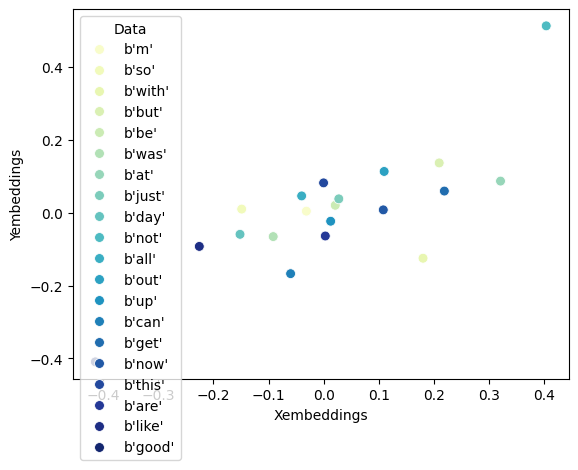

In [ ]:
sns.scatterplot(
    x='Xembeddings',
    y='Yembeddings',
    data=spaceEmbeddings,
    hue='Data',
    palette='YlGnBu',
    s=50
)

- We can see that some words are already in the same **space embeddings**, this means that the model has already learned that these **phrases are similar**

- Now, let's test the model by **feeding it a few sentences to analyze sentiment**

In [ ]:
text=tf.constant(['this movie is good !'.split()])

In [ ]:
encode_words=tableLookup.lookup(text)

In [ ]:
encode_words

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[  36,  217,   10,   39, 2486]])>

- **Performing the prediction**

In [ ]:
y_pred=model.predict(encode_words)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


In [ ]:
y_pred

array([[9.7804390e-05, 3.7771356e-03, 9.9612504e-01]], dtype=float32)

In [ ]:
y_pred[0].argmax()

2

- The model correctly classified this as a **positive instance**

##**4.1-Masking**

- The instances **'pad'** are fill, we want that de model  ignore these words **because they don't represent anything, they're just fill.**

- To make the model ignore the instances **'pad'** we need to create a mask.

- The embeddings layer creates a **Boolean tensor mask** with the same format as the inputs where each instance **<pad>** is **assigned as 0**.. To do this, we need to create a mask using the **Functional API**




- The idea is to make the network ignore the tokens **'pad'**, this is because the tokens **'pad'** are just padding so that the network **processes sequences** of the same size, in other words, **they are not important**.

- The **idea of masking** is to make it possible for the network to ignore instances that are **'pad' tokens**, that is, with masking, when the network finds an instance that is a 'pad' token, the **model will simply ignore the instance of that time interval and will copy the instance of the previous time interval**

- The other attention we need to have is that the penultimate **layer cannot return sequences**, because we cannot propagate the tokens **'pad'** to the l**ast layer of output.**

##**4.2-Creating the masking**

In [ ]:
k=keras.backend

In [ ]:
InputLayer=keras.layers.Input(shape=[None]) #recurring layers process sequences of arbitrary size
mask=keras.layers.Lambda(lambda inputs:k.not_equal(inputs,0))(InputLayer) #creating the masking
z=keras.layers.Embedding(input_dim=len(truncated_vocab) + out_of_vocabulary,output_dim=2)(InputLayer)
gruCell=keras.layers.GRU(50,return_sequences=True,use_cudnn=False)(z,mask=mask)
gruCell=keras.layers.GRU(50,use_cudnn=False)(gruCell,mask=mask)
outputLayer=keras.layers.Dense(3,activation='softmax')(gruCell)
model_without_pad=keras.Model(inputs=[InputLayer],outputs=[outputLayer])

In [ ]:
model_without_pad.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 2)        │          5,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, None)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_9 (GRU)               │ (None, None, 50)       │          8,100 │ embedding_4[0][0],     │
│                           │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_10 (GRU)              │ (None, 50)             │         15,300 │ gru_9[0][0],           │
│                           │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 3)              │            153 │ gru_10[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 28,553 (111.54 KB)

 Trainable params: 28,553 (111.54 KB)

 Non-trainable params: 0 (0.00 B)

- Building the **Masking Model**

In [ ]:
model_without_pad.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
        'accuracy'
    ]
)

- **Training the masking model**.

In [ ]:
model_history=model_without_pad.fit(
    dataset_train,
    epochs=32,
    batch_size=16
)

Epoch 1/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4713 - loss: 1.0106
Epoch 2/32
  5/859 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6073 - loss: 0.8300 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6632 - loss: 0.7654
Epoch 3/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6978 - loss: 0.7059
Epoch 4/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7086 - loss: 0.6862
Epoch 5/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7138 - loss: 0.6733
Epoch 6/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7232 - loss: 0.6568
Epoch 7/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7315 - loss: 0.6363
Epoch 8/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7415 - loss: 0.6194
Epoch 9/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7477 - loss: 0.6071
Epoch 10/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7507 - loss: 0.5978
Epoch 11/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7538 - loss: 0.5901
Epoch 12/32
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7571 - loss: 0.5830
Epoch 13/32
859/859 ━━━━━━━━━━━━━━━━━━━━

- Viewing the **Mask Model Result**

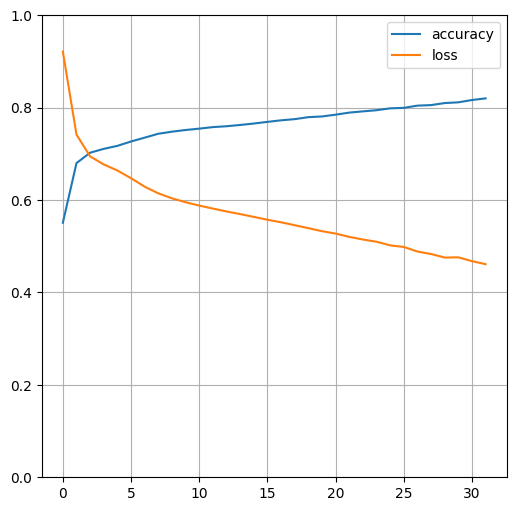

In [ ]:
pd.DataFrame(
    model_history.history
).plot(
    figsize=(6,6)
)
plt.gca().set_ylim(0,1)
plt.grid(True)

- We can see that the model's performance with masking was much **more efficient**.

#**5-Pre-trained embeddings**

- According to ***Aurélien Géron's book***, it is always better to use **pre-trained embeddings** than to train your own **embeddings**

- ***link*** [Book "Hands-On Machine Learning with Scikit-Learn and TensorFlow"](https://www.amazon.com.br/M%C3%A3os-obra-aprendizado-Scikit-Learn-inteligentes/dp/8550815489)


- To do this, we'll use **tensorflow_hub** to download the weights of the **pre-trained embeddings**

In [ ]:
import tensorflow_hub as hub

In [ ]:
from functools import partial

In [ ]:
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

In [ ]:
pre_trained_embeddings=keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1',
                   dtype=tf.string,
                   input_shape=[],
                   output_shape=[50],
                   trainable=True #We will adjust the pre trained embeddings.
          ),
    keras.layers.Dense(128,activation='relu',kernel_initializer='he_normal'),
    keras.layers.Dense(128,activation='relu',kernel_initializer='he_normal'),
    keras.layers.Dense(3,activation='softmax')
])

- When we are using **pre-trained layers**, it is recommended to **freeze the lower layers** and **train the upper layers** that we have added, then after training the upper layers, **we can propagate all the gradients to the entire network**

- Freezing the  ***lower layers***

- Training the **base model**

In [ ]:
dataset_base=tf.data.TFRecordDataset(['/content/sentiment_analysis.tfrecords']).interleave(
    lambda filepaths:tf.data.TextLineDataset(filepaths).skip(1),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
) #Preparing the dataset

In [ ]:
dataset_base = dataset_base.map(preprocess)  # Applying the preprocessing function
dataset_base = dataset_base.batch(32)        # Batching with batch size 32
dataset_base = dataset_base.prefetch(1)      # Prefetching 1 batch to speed up training


In [ ]:
class PreTrainedEmbeddings:
  def __init__(self,dataset):
    self.dataset=dataset_base
    self.model_pre_trained=pre_trained_embeddings
    self.model_history=None

  def compileModel(self):
    self.model_pre_trained.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy']
    )

  def trainConfig(self,trainable=False):
    if trainable is False:
      for layers in self.model_pre_trained.layers[:-2]:#Freezing the lower layers
          layers.trainable=trainable

      self.compileModel()
      self.model_history=self.model_pre_trained.fit(
          self.dataset,
          epochs=10
      )
    else:
      for layers in self.model_pre_trained.layers[:]:#Thawing the Bottom Layers
          layers.trainable=trainable
      self.compileModel()
      self.model_history=self.model_pre_trained.fit(
          self.dataset,
          epochs=10
      )

In [ ]:
configModel=PreTrainedEmbeddings(dataset_base)

In [ ]:
configModel.trainConfig(trainable=False) #training Freezing the lower layers

Epoch 1/10
859/859 [==============================] - 4s 3ms/step - loss: 1.0064 - accuracy: 0.4967
Epoch 2/10
859/859 [==============================] - 3s 3ms/step - loss: 0.9771 - accuracy: 0.5237
Epoch 3/10
859/859 [==============================] - 3s 3ms/step - loss: 0.9648 - accuracy: 0.5312
Epoch 4/10
859/859 [==============================] - 3s 3ms/step - loss: 0.9531 - accuracy: 0.5377
Epoch 5/10
859/859 [==============================] - 3s 3ms/step - loss: 0.9426 - accuracy: 0.5448
Epoch 6/10
859/859 [==============================] - 3s 3ms/step - loss: 0.9329 - accuracy: 0.5516
Epoch 7/10
859/859 [==============================] - 3s 3ms/step - loss: 0.9237 - accuracy: 0.5583
Epoch 8/10
859/859 [==============================] - 3s 3ms/step - loss: 0.9155 - accuracy: 0.5656
Epoch 9/10
859/859 [==============================] - 3s 3ms/step - loss: 0.9074 - accuracy: 0.5718
Epoch 10/10
859/859 [==============================] - 3s 3ms/step - loss: 0.8998 - accuracy: 0.5776

- Now we need to thaw the **bottom layers** **and propagate the gradients to all the layers.**

In [ ]:
configModel.trainConfig(trainable=True) #propagate the gradients to all the layers

Epoch 1/10
859/859 [==============================] - 22s 25ms/step - loss: 0.8114 - accuracy: 0.6291
Epoch 2/10
859/859 [==============================] - 4s 5ms/step - loss: 0.4963 - accuracy: 0.8031
Epoch 3/10
859/859 [==============================] - 4s 5ms/step - loss: 0.2569 - accuracy: 0.9129
Epoch 4/10
859/859 [==============================] - 4s 5ms/step - loss: 0.1070 - accuracy: 0.9709
Epoch 5/10
859/859 [==============================] - 4s 5ms/step - loss: 0.0461 - accuracy: 0.9900
Epoch 6/10
859/859 [==============================] - 4s 5ms/step - loss: 0.0270 - accuracy: 0.9952
Epoch 7/10
859/859 [==============================] - 4s 5ms/step - loss: 0.0206 - accuracy: 0.9952
Epoch 8/10
859/859 [==============================] - 4s 5ms/step - loss: 0.0170 - accuracy: 0.9960
Epoch 9/10
859/859 [==============================] - 4s 5ms/step - loss: 0.0111 - accuracy: 0.9975
Epoch 10/10
859/859 [==============================] - 4s 5ms/step - loss: 0.0086 - accuracy: 0.99

- Viewing the results of **pre-trained embeddings**

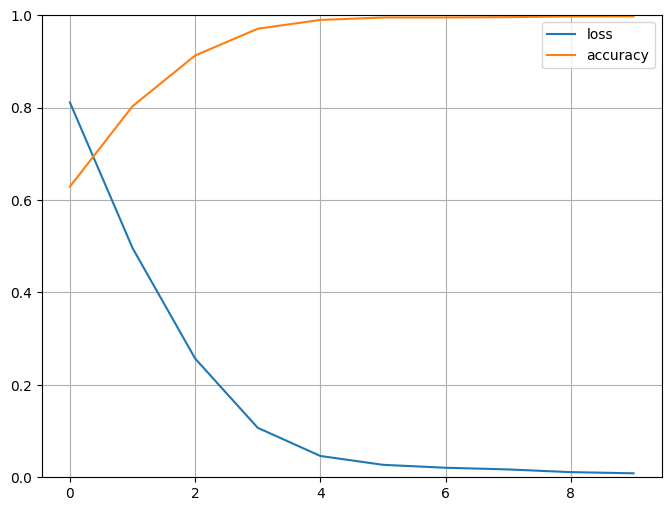

In [ ]:
pd.DataFrame(
    configModel.model_history.history
).plot(
    figsize=(8,6)
)
plt.gca().set_ylim(0,1)
plt.grid(True)

- We can see that the results of the **pre-trained** model are much more **efficient compared to the others** ...

 ## **5.1-Testing the pre-trained model**

In [ ]:
text=tf.constant(['bad movie , is not good !'])

In [ ]:
y_pred=configModel.model_pre_trained.predict(text)

1/1 [==============================] - 0s 113ms/step


In [ ]:
y_pred

array([[9.9973637e-01, 2.0853787e-04, 5.5101587e-05]], dtype=float32)

In [ ]:
y_pred[0].argmax()


0

- The model **correctly analyzed that this is a negative** prediction.

# **6-Putting the model into production**

-  After we **train our model**, we can put it into production using **tensorflow serving**

In [ ]:
import os

- Creating the Template **Directory and Version**

In [ ]:
model_version = "0001"  # Specifies the version of the model.
model_name = "my_sentiment_model"  # Defines the name of the sentiment analysis model.
model_path = os.path.join(model_name, model_version)  # Constructs the directory path to the model using the model name and version.


In [ ]:
tf.saved_model.save(configModel.model_pre_trained, model_path) #Saving the Model

In [ ]:
#Viewing Model Information
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

2024-09-25 13:33:07.556116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 13:33:07.575385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 13:33:07.581209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 13:33:08.756049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains

In [ ]:
!saved_model_cli show --dir {model_path} --all

2024-09-25 13:33:11.976884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 13:33:11.995848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 13:33:12.001621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 13:33:13.150308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the followin

In [ ]:
'''
This code is extracting the directory where the template file is located and storing that path in the
"MODEL_DIR" environment variable,
making it easier to access the directory path where the template is.
'''

os.environ["MODEL_DIR"] = os.path.split(os.path.abspath(model_path))[0]

In [ ]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
# TODO: Use the latest model server version when colab supports it.
#!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server
# We need to install Tensorflow Model server 2.8 instead of latest version
# Tensorflow Serving >2.9.0 required `GLIBC_2.29` and `GLIBCXX_3.4.26`. Currently colab environment doesn't support latest version of`GLIBC`,so workaround is to use specific version of Tensorflow Serving `2.8.0` to mitigate issue.
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb'
!dpkg -i tensorflow-model-server_2.8.0_all.deb
!pip3 install tensorflow-serving-api==2.8.0

--2024-09-25 13:33:22--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340152790 (324M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 324.39M  93.8MB/s    in 3.7s    

2024-09-25 13:33:26 (88.4 MB/s) - ‘tensorflow-model-server_2.8.0_all.deb’ saved [340152790/340152790]

Selecting previously unselected package tensorflow-model-server.
(Reading database ... 123605 files and directories currently installed.)
Preparing to unpack tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
     --rest_api_port=8502 \
     --model_name=my_mnist_model \
     --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
# tail server.log: Displays the last lines of server.log, showing TensorFlow Serving's output and errors.
!tail server.log

2024-09-25 13:33:39.050680: E external/org_tensorflow/tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: NOT_FOUND: Op type not registered 'DisableCopyOnRead' in binary running on 8a6146d22a98. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
	when importing GraphDef to MLIR module in GrapplerHook
2024-09-25 13:33:39.087433: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute debug_name which is not in the op definition: Op<name=VarHandleOp; signature= -> resource:resource; attr=container:string,default=""; attr=shared_name:string,default=""; attr=dtype:type; attr=shape:shape; attr=allowed_devices:list(string),default=[]; is_stateful=true> This may

- Once the ***server is running***, we can use **that same model and make predictions**

##**6.1-Making predictions with tensorflow serving**

- Creating a new **instance** ***X_new***

In [ ]:
X_new=['this movie is not  good']

In [ ]:
import json

input_data_json = json.dumps({
    "signature_name": "serving_default", #Preparing the data for submission.
    "instances": X_new
})

In [ ]:
import requests

SERVER_URL = 'http://localhost:8502/v1/models/my_mnist_model:predict'
response = requests.post(SERVER_URL, data=input_data_json) #Making the request
response.raise_for_status()
response = response.json() #Getting the requisition data

In [ ]:
response #Getting the Model Results

{'predictions': [[0.989941657, 0.0100395652, 1.87672813e-05]]}

- Creating a **Data Structure (Queue)** to Queue Multiple Data for **Submission on the Server**

In [ ]:
class QueueNodeList:
  def __init__(self,name,text):
    self.name=name
    self.text=text
    self.next=None

  def impressNo(self):
    return f'Name:{self.name}-text:{self.text}'

In [ ]:
class LinkedListQueue:
  def __init__(self):
    self.head=None
    self.tail=None
    self.counter=0

  def enqueue(self,name,text):
    Node=QueueNodeList(name,text)

    if self.head is None:
      self.head=Node
      self.tail=Node

    else:
      self.tail.next=Node
      self.tail=Node

    self.counter+=1
    return self.tail

  def dequeue(self):
    try:
      if self.counter ==0:
        raise Exception(f'Error the list is empty')
      else:
        current=self.head
        self.head=self.head.next
        return current
    except (ValueError) as e:
      print(f'The list is empty ..')

  def impress(self):

    if self.counter==0:
      print(f'Error the list is empty !')

    current=self.head

    while current :
      print(current.impressNo())
      current=current.next


In [ ]:
queue=LinkedListQueue()

In [ ]:
#Queuing multiple data

queue.enqueue('Alexandre', 'This movie is fantastic! I loved every moment!')
queue.enqueue('Bruno', 'The movie was quite dull and dragged on too long.')
queue.enqueue('Jason', 'An average film, nothing special, but entertaining.')
queue.enqueue('Neusa', 'Absolutely loved it! A masterpiece of cinema!')
queue.enqueue('Pedro', 'I found it really boring and predictable.')
queue.enqueue('Maria', 'Great plot twists! Kept me on the edge of my seat.')
queue.enqueue('Clara', 'The acting was subpar, really disappointing.')
queue.enqueue('Fernando', 'What a delightful film! Highly recommend it.')
queue.enqueue('Sofia', 'It was okay, but I expected more from the director.')
queue.enqueue('Gustavo', 'An incredible experience! I will watch it again!')


In [ ]:
queue.impress()

Name:Alexandre-text:This movie is fantastic! I loved every moment!
Name:Bruno-text:The movie was quite dull and dragged on too long.
Name:Jason-text:An average film, nothing special, but entertaining.
Name:Neusa-text:Absolutely loved it! A masterpiece of cinema!
Name:Pedro-text:I found it really boring and predictable.
Name:Maria-text:Great plot twists! Kept me on the edge of my seat.
Name:Clara-text:The acting was subpar, really disappointing.
Name:Fernando-text:What a delightful film! Highly recommend it.
Name:Sofia-text:It was okay, but I expected more from the director.
Name:Gustavo-text:An incredible experience! I will watch it again!


In [ ]:
name_=[]
text_=[]

In [ ]:
#Extracting the data from the queue

current=queue.head

while current :
  name_.append(current.name)
  text_.append(current.text)
  current=current.next

dataframe=pd.DataFrame(
    {
        'Nome':name_,
        'text':text_
    }
)

dataframe

,Nome,text
0,Alexandre,This movie is fantastic! I loved every moment!
1,Bruno,The movie was quite dull and dragged on too long.
2,Jason,"An average film, nothing special, but entertai..."
3,Neusa,Absolutely loved it! A masterpiece of cinema!
4,Pedro,I found it really boring and predictable.
5,Maria,Great plot twists! Kept me on the edge of my s...
6,Clara,"The acting was subpar, really disappointing."
7,Fernando,What a delightful film! Highly recommend it.
8,Sofia,"It was okay, but I expected more from the dire..."
9,Gustavo,An incredible experience! I will watch it again!


- Performing multiple **post requests**, to perform predictions with **TensorFlow Serving**

In [ ]:
#- Performing multiple **post requests**, to perform predictions with **TensorFlow
input_data_json=json.dumps({
      "signature_name":"serving_default",
      "instances":text_
  })
response=requests.post(SERVER_URL,data=input_data_json)
response=response.json()
print(response)

{'predictions': [[1.7655746e-05, 0.0128439842, 0.987138331], [0.997932076, 0.00133975013, 0.000728175452], [0.986447692, 0.0134193087, 0.000133044945], [4.89216712e-09, 2.74668855e-06, 0.999997258], [0.999997139, 2.62624485e-06, 2.49753811e-07], [0.833264, 0.149343073, 0.0173928756], [0.0881966278, 0.0802387223, 0.831564665], [4.32627156e-10, 2.767976e-05, 0.999972343], [0.012204024, 0.985671759, 0.00212416914], [4.2642426e-12, 9.88760576e-07, 0.999999046]]}


In [ ]:
response['predictions']

[[1.7655746e-05, 0.0128439842, 0.987138331],
 [0.997932076, 0.00133975013, 0.000728175452],
 [0.986447692, 0.0134193087, 0.000133044945],
 [4.89216712e-09, 2.74668855e-06, 0.999997258],
 [0.999997139, 2.62624485e-06, 2.49753811e-07],
 [0.833264, 0.149343073, 0.0173928756],
 [0.0881966278, 0.0802387223, 0.831564665],
 [4.32627156e-10, 2.767976e-05, 0.999972343],
 [0.012204024, 0.985671759, 0.00212416914],
 [4.2642426e-12, 9.88760576e-07, 0.999999046]]

In [ ]:
y_pred={}

In [ ]:
counter_neg = 0
counter_pos = 0

y_pred['negative_sentiment'] = []
y_pred['positive_sentiment'] = []

for predict in np.asarray(response['predictions']):
    argmax = predict.argmax()
    if argmax == 0:
        counter_neg += 1
        y_pred['negative_sentiment'] = [counter_neg]
    elif argmax == 2:
        counter_pos += 1
        y_pred['positive_sentiment'] = [counter_pos]


<ipython-input-153-c84363843558>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Count', y='Sentiment', data=data, palette='muted', edgecolor='black')


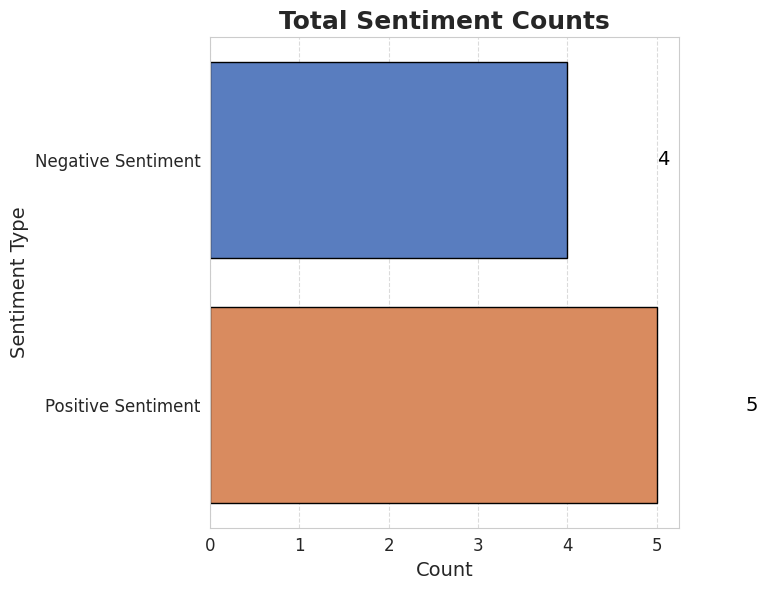

In [ ]:
negative_count = sum(y_pred['negative_sentiment'])
positive_count = sum(y_pred['positive_sentiment'])

data = pd.DataFrame({
    'Sentiment': ['Negative Sentiment', 'Positive Sentiment'],
    'Count': [negative_count, positive_count]
})

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
bar_plot = sns.barplot(x='Count', y='Sentiment', data=data, palette='muted', edgecolor='black')

for index, row in data.iterrows():
    bar_plot.text(row['Count'] + 1, index, row['Count'], color='black', va='center', fontsize=14)

plt.title('Total Sentiment Counts', fontsize=18, fontweight='bold')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Sentiment Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


- We can see that the model is **doing very well**.. So, we put the model into production with **TensorFlow Serving**, we queue up several **comments** creating a data structure.. and finally we **visualize the predictions made by the model**

- What can we **conclude from this?**

#**7-Conclusion**

- Sentiment analysis can be very important to **understand various aspects**.. However, the most important thing for our problem is to **monitor the sentiment reception of the products sold by the company**

- **Understanding customer sentiments** for each product sold by the company will definitely help the company to have a **greater understanding** of how its **products are being accepted by customers**